In [59]:
from data_generator import dgen, pack_by_value, downscale_nsave, Camera_source, data_generator, dir_source, resize_tuple
from fit_pca import plot_images_table, get_pca_sk_transformer

import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

import os, time, shutil

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
# an optional path of where to save data
path = "D:\LabData\img"

#downscale_nsave(path,'small',factor=0.2)

In [77]:
#source = Levenh_source(path)
def pipeline(path,experiment):
    source  = Levenh_source(path)
    data_gen = data_generator(source,experiment)
    resized = resize_tuple(data_gen)
    return resized


In [78]:
#imgs = [d[0] for d in data]

#plot_images_table(imgs[:5],columns=5,figsize=(15,35))

def pipeline():
    imgs = Camera_source()

In [79]:
n_components = 20
train_gen = pipeline(path,experiment)
train_data = []
for t in train_gen:
    train_data.append(t)
    print(t[1])
    beep()

pca_gen, transformed = get_pca_sk_transformer((d[0][:,:,1] for d in train_data),n_components=n_components)

X_train, y_train = np.array(transformed)/256, np.array([d[1] for d in train_data])
y_train -= np.mean(y_train)
y_train /= np.std(y_train)
y_train-=np.min(y_train)
packed = pack_by_value(train_data)
pack_sizes = [len(p[1]) for p in packed]
np.random.seed(42)
validate = np.array([np.random.randint(0,s) for s in pack_sizes])
cum = np.cumsum([0]+pack_sizes)

validate = validate+cum[:-1]
print('validating on this indices:',validate)
train = np.delete(range(len(X_train)),validate)
print("X,y shape:",X_train.shape,y_train.shape)
print(y_train)

Watching img/Levenh for new files...
found first image, running ok...
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(1.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)
(2.0,)

 [3.10161782]]


In [86]:
# reset the data!
shutil.rmtree(path)
os.makedirs(path)

In [81]:
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Input, Flatten, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam

In [82]:
#layers

first = 20
second = 10
out = 1

In [83]:
inp_shape = X_train.shape[1:]
print("Xtrain shape",inp_shape)
inp = Input(shape = inp_shape)
x = Dense(first, activation='relu')(inp)
x = Dense(second, activation='relu')(x)
x = Dense(out, activation='relu')(x)
model = Model(inp, x)
opt = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00001, amsgrad=False)

model.compile(loss='mse',optimizer=opt)

Xtrain shape (20,)


In [84]:
model.fit(X_train[train], y_train[train],
          batch_size=40, 
          epochs=500,
          shuffle=True,
          validation_data=(X_train[validate], y_train[validate]))

Train on 665 samples, validate on 9 samples
Epoch 1/500
665/665 [==============================] - ETA: 8s - loss: 3.902 - 1s 980us/step - loss: 2.3364 - val_loss: 1.1825
Epoch 2/500
665/665 [==============================] - ETA: 0s - loss: 1.261 - 0s 48us/step - loss: 0.7883 - val_loss: 0.2493
Epoch 3/500
665/665 [==============================] - ETA: 0s - loss: 0.307 - 0s 47us/step - loss: 0.1270 - val_loss: 0.0501
Epoch 4/500
665/665 [==============================] - ETA: 0s - loss: 0.058 - 0s 54us/step - loss: 0.0365 - val_loss: 0.0365
Epoch 5/500
665/665 [==============================] - ETA: 0s - loss: 0.020 - 0s 48us/step - loss: 0.0235 - val_loss: 0.0207
Epoch 6/500
665/665 [==============================] - ETA: 0s - loss: 0.023 - 0s 56us/step - loss: 0.0211 - val_loss: 0.0223
Epoch 7/500
665/665 [==============================] - ETA: 0s - loss: 0.011 - 0s 51us/step - loss: 0.0197 - val_loss: 0.0204
Epoch 8/500
665/665 [==============================] - ETA: 0s - loss: 0.

Epoch 62/500
665/665 [==============================] - ETA: 0s - loss: 2.5557e-0 - 0s 46us/step - loss: 3.0026e-04 - val_loss: 2.2538e-04
Epoch 63/500
665/665 [==============================] - ETA: 0s - loss: 1.8978e-0 - 0s 44us/step - loss: 2.9893e-04 - val_loss: 2.1677e-04
Epoch 64/500
665/665 [==============================] - ETA: 0s - loss: 1.4724e-0 - 0s 60us/step - loss: 3.0889e-04 - val_loss: 1.6868e-04
Epoch 65/500
665/665 [==============================] - ETA: 0s - loss: 4.6809e-0 - 0s 54us/step - loss: 2.9328e-04 - val_loss: 2.0842e-04
Epoch 66/500
665/665 [==============================] - ETA: 0s - loss: 2.0047e-0 - 0s 53us/step - loss: 2.9504e-04 - val_loss: 3.2205e-04
Epoch 67/500
665/665 [==============================] - ETA: 0s - loss: 2.2426e-0 - 0s 53us/step - loss: 2.9308e-04 - val_loss: 1.5893e-04
Epoch 68/500
665/665 [==============================] - ETA: 0s - loss: 1.6455e-0 - 0s 50us/step - loss: 2.9523e-04 - val_loss: 3.4920e-04
Epoch 69/500
665/665 [=====

Epoch 121/500
665/665 [==============================] - ETA: 0s - loss: 8.7143e-0 - 0s 44us/step - loss: 2.0912e-04 - val_loss: 1.0062e-04
Epoch 122/500
665/665 [==============================] - ETA: 0s - loss: 5.8679e-0 - 0s 51us/step - loss: 1.7654e-04 - val_loss: 8.8409e-05
Epoch 123/500
665/665 [==============================] - ETA: 0s - loss: 9.2917e-0 - 0s 50us/step - loss: 2.1121e-04 - val_loss: 9.4413e-05
Epoch 124/500
665/665 [==============================] - ETA: 0s - loss: 2.4316e-0 - 0s 43us/step - loss: 1.9140e-04 - val_loss: 9.3128e-05
Epoch 125/500
665/665 [==============================] - ETA: 0s - loss: 2.2412e-0 - 0s 48us/step - loss: 1.8691e-04 - val_loss: 1.7912e-04
Epoch 126/500
665/665 [==============================] - ETA: 0s - loss: 8.4934e-0 - 0s 51us/step - loss: 1.8304e-04 - val_loss: 7.8665e-05
Epoch 127/500
665/665 [==============================] - ETA: 0s - loss: 1.5707e-0 - 0s 38us/step - loss: 1.9715e-04 - val_loss: 2.0293e-04
Epoch 128/500
665/66

Epoch 238/500
665/665 [==============================] - ETA: 0s - loss: 6.0265e-0 - 0s 42us/step - loss: 9.8195e-05 - val_loss: 5.9314e-05
Epoch 239/500
665/665 [==============================] - ETA: 0s - loss: 3.6541e-0 - 0s 51us/step - loss: 9.1939e-05 - val_loss: 4.1358e-05
Epoch 240/500
665/665 [==============================] - ETA: 0s - loss: 3.1289e-0 - 0s 53us/step - loss: 8.3790e-05 - val_loss: 8.2878e-05
Epoch 241/500
665/665 [==============================] - ETA: 0s - loss: 5.1606e-0 - 0s 53us/step - loss: 1.0225e-04 - val_loss: 8.2067e-05
Epoch 242/500
665/665 [==============================] - ETA: 0s - loss: 8.9138e-0 - 0s 50us/step - loss: 8.8063e-05 - val_loss: 8.5413e-05
Epoch 243/500
665/665 [==============================] - ETA: 0s - loss: 4.8413e-0 - 0s 47us/step - loss: 9.9114e-05 - val_loss: 6.9221e-05
Epoch 244/500
665/665 [==============================] - ETA: 0s - loss: 5.9698e-0 - 0s 56us/step - loss: 9.3037e-05 - val_loss: 7.2024e-05
Epoch 245/500
665/66

Epoch 355/500
665/665 [==============================] - ETA: 0s - loss: 4.6550e-0 - 0s 39us/step - loss: 1.1381e-04 - val_loss: 9.9325e-05
Epoch 356/500
665/665 [==============================] - ETA: 0s - loss: 1.2774e-0 - 0s 53us/step - loss: 1.3068e-04 - val_loss: 1.0636e-04
Epoch 357/500
665/665 [==============================] - ETA: 0s - loss: 8.4973e-0 - 0s 56us/step - loss: 9.4067e-05 - val_loss: 1.5540e-04
Epoch 358/500
665/665 [==============================] - ETA: 0s - loss: 1.2190e-0 - 0s 45us/step - loss: 1.1268e-04 - val_loss: 4.4562e-05
Epoch 359/500
665/665 [==============================] - ETA: 0s - loss: 2.5215e-0 - 0s 50us/step - loss: 5.6832e-05 - val_loss: 1.6746e-05
Epoch 360/500
665/665 [==============================] - ETA: 0s - loss: 7.5841e-0 - 0s 39us/step - loss: 1.6088e-04 - val_loss: 4.3213e-04
Epoch 361/500
665/665 [==============================] - ETA: 0s - loss: 6.5808e-0 - 0s 46us/step - loss: 2.4660e-04 - val_loss: 8.7057e-05
Epoch 362/500
665/66

Epoch 472/500
665/665 [==============================] - ETA: 0s - loss: 1.0519e-0 - 0s 41us/step - loss: 6.2700e-05 - val_loss: 8.1854e-05
Epoch 473/500
665/665 [==============================] - ETA: 0s - loss: 8.5787e-0 - 0s 46us/step - loss: 5.2673e-05 - val_loss: 3.2993e-05
Epoch 474/500
665/665 [==============================] - ETA: 0s - loss: 6.7915e-0 - 0s 60us/step - loss: 6.2788e-05 - val_loss: 1.0315e-04
Epoch 475/500
665/665 [==============================] - ETA: 0s - loss: 1.3156e-0 - 0s 48us/step - loss: 1.0213e-04 - val_loss: 1.1427e-04
Epoch 476/500
665/665 [==============================] - ETA: 0s - loss: 1.2689e-0 - 0s 53us/step - loss: 8.5536e-05 - val_loss: 2.0682e-04
Epoch 477/500
665/665 [==============================] - ETA: 0s - loss: 1.9866e-0 - 0s 59us/step - loss: 3.1459e-04 - val_loss: 7.3652e-04
Epoch 478/500
665/665 [==============================] - ETA: 0s - loss: 5.1740e-0 - 0s 50us/step - loss: 4.2162e-04 - val_loss: 1.5481e-04
Epoch 479/500
665/66

In [87]:
path_test = "img/Levenh"
now = time.time()
experiment_test = Dict2Obj({
    "start_time":now,  #time.mktime((2018,9,24,19,39,4,0,0,0)),
    "tick":10,
    "transition_dur":1,
})
source  = Levenh_source(path_test)
data_gen = data_generator(source,experiment_test)
resized = resize_tuple(data_gen)
pca_ed = pca_gen( (d[0][:,:,1] for d in resized) )
#predictor = model.predict_generator(pca_ed)
for x in pca_ed:
    x = np.array(x)/256
    pred = model.predict(x)
    print('predicted:',pred)


Watching img/Levenh for new files...
found first image, running ok...
predicted: [[1.9695189]]
predicted: [[1.9473377]]
predicted: [[1.9576715]]
predicted: [[1.9540902]]
predicted: [[2.1771529]]
predicted: [[2.884848]]
predicted: [[2.774379]]
predicted: [[2.6243262]]
predicted: [[1.0778364]]
predicted: [[1.239842]]
predicted: [[2.010715]]
predicted: [[2.6066961]]
predicted: [[2.019249]]
predicted: [[1.2835126]]
predicted: [[1.2783725]]
predicted: [[1.2840862]]
predicted: [[0.27407986]]
predicted: [[0.2942214]]
predicted: [[0.32399338]]
predicted: [[0.31811428]]
predicted: [[0.35291156]]
predicted: [[0.34626463]]
predicted: [[0.31706712]]
predicted: [[0.33866557]]
predicted: [[0.34702134]]
predicted: [[0.34950614]]
predicted: [[0.35073712]]
predicted: [[0.35416526]]
predicted: [[0.33850908]]
predicted: [[0.3440132]]
predicted: [[0.30641025]]
predicted: [[0.37989473]]
predicted: [[0.38439628]]
predicted: [[0.361011]]
predicted: [[0.34108508]]
predicted: [[0.2892669]]
predicted: [[0.33473

In [ ]:
from sklearn.externals import joblib # saving pca
_ = joblib.dump(pca, 'PCA'+str(n_components)+'.save')

In [ ]:
pca = joblib.load('PCA'+str(n_components)+'.save')

In [18]:
transformed = pca.transform(X)

In [30]:
transformed = transformed/transformed.max()


In [39]:
angles = np.array([d[1] for d in data])
angles = angels - angels.min()
angles

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  9.,
        9.,  9.,  9.,  9.,  9., 10., 10., 10., 10., 10., 10., 10., 11.,
       11., 11., 11., 11., 11., 11., 12., 12., 12., 12., 12., 12., 12.,
       13., 13., 13., 13., 13., 13., 13.])

In [43]:
enc = OneHotEncoder()
enc.fit(angles.reshape(len(angles),1))
trAng = enc.transform(angles.reshape(len(angles),1))

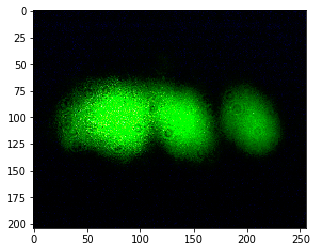

In [55]:
#X = [np.array(d.getdata()).flatten() for d in imgs]
X = np.array(X).reshape(len(X), 204, 256, 3)

import matplotlib.pyplot as plt
plt.imshow((X[0]).astype(np.uint8), interpolation='nearest')

In [50]:
test = np.cumsum([0, 6, 7, 7, 7, 8, 7, 8, 7, 7, 6, 7, 7, 7])
train = np.delete(range(len(X)), test)

NameError: name 'X' is not defined

In [209]:
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Input, Flatten, BatchNormalization
from keras.models import Model

In [217]:
#layers
first = 20
second = 10
out = 1

In [253]:
inp = Input(shape = (204, 256, 3))
x = MaxPooling2D((2, 2), padding='same')(inp)
x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((20, 20), padding='same')(x)
x = Conv2D(1, (2, 2), activation='relu', padding='same')(x)
#x = MaxPooling2D((10, 10), padding='same')(x)
x = Flatten()(x)
x = Dense(first, activation='relu')(x)
x = Dense(second, activation='relu')(x)
x = Dense(out, activation='relu')(x)
model = Model(inp, x)
model.compile(loss='mae', optimizer='adam')

In [254]:
model.fit(X[train]/256, angles[train]%10/10, batch_size=4, epochs=300, shuffle=True, validation_data=(X[test]/256, angles[test]%10/10))

Train on 84 samples, validate on 14 samples
Epoch 1/300
84/84 [==============================] - ETA: 1:00 - loss: 0.350 - ETA: 13s - loss: 0.425 - ETA: 6s - loss: 0.3679 - ETA: 3s - loss: 0.380 - ETA: 1s - loss: 0.369 - ETA: 0s - loss: 0.359 - 4s 42ms/step - loss: 0.3655 - val_loss: 0.3643
Epoch 2/300
84/84 [==============================] - ETA: 0s - loss: 0.575 - ETA: 0s - loss: 0.375 - ETA: 0s - loss: 0.346 - ETA: 0s - loss: 0.334 - ETA: 0s - loss: 0.355 - ETA: 0s - loss: 0.358 - 0s 5ms/step - loss: 0.3655 - val_loss: 0.3643
Epoch 3/300
84/84 [==============================] - ETA: 0s - loss: 0.325 - ETA: 0s - loss: 0.310 - ETA: 0s - loss: 0.319 - ETA: 0s - loss: 0.351 - ETA: 0s - loss: 0.364 - 0s 4ms/step - loss: 0.3655 - val_loss: 0.3643
Epoch 4/300
84/84 [==============================] - ETA: 0s - loss: 0.325 - ETA: 0s - loss: 0.330 - ETA: 0s - loss: 0.359 - ETA: 0s - loss: 0.354 - ETA: 0s - loss: 0.331 - ETA: 0s - loss: 0.348 - 0s 5ms/step - loss: 0.3655 - val_loss: 0.3643
Epo

84/84 [==============================] - ETA: 0s - loss: 0.040 - ETA: 0s - loss: 0.037 - ETA: 0s - loss: 0.038 - ETA: 0s - loss: 0.036 - ETA: 0s - loss: 0.039 - ETA: 0s - loss: 0.040 - ETA: 0s - loss: 0.040 - 0s 5ms/step - loss: 0.0430 - val_loss: 0.0564
Epoch 64/300
84/84 [==============================] - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.026 - ETA: 0s - loss: 0.051 - ETA: 0s - loss: 0.041 - ETA: 0s - loss: 0.040 - ETA: 0s - loss: 0.039 - ETA: 0s - loss: 0.039 - 0s 5ms/step - loss: 0.0410 - val_loss: 0.0584
Epoch 65/300
84/84 [==============================] - ETA: 0s - loss: 0.103 - ETA: 0s - loss: 0.043 - ETA: 0s - loss: 0.049 - ETA: 0s - loss: 0.049 - ETA: 0s - loss: 0.049 - ETA: 0s - loss: 0.047 - 0s 5ms/step - loss: 0.0471 - val_loss: 0.0582
Epoch 66/300
84/84 [==============================] - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.035 - ETA: 0s - loss: 0.030 - ETA: 0s - loss: 0.046 - ETA: 0s - loss: 0.044 - ETA: 0s - loss: 0.044 - ETA: 0s - loss: 0.041 - 0s 5ms/step

Epoch 125/300
84/84 [==============================] - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.018 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.023 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.024 - 0s 5ms/step - loss: 0.0251 - val_loss: 0.0431
Epoch 126/300
84/84 [==============================] - ETA: 0s - loss: 0.032 - ETA: 0s - loss: 0.036 - ETA: 0s - loss: 0.026 - ETA: 0s - loss: 0.025 - ETA: 0s - loss: 0.023 - ETA: 0s - loss: 0.023 - ETA: 0s - loss: 0.025 - 0s 6ms/step - loss: 0.0269 - val_loss: 0.0392
Epoch 127/300
84/84 [==============================] - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.022 - ETA: 0s - loss: 0.025 - ETA: 0s - loss: 0.022 - ETA: 0s - loss: 0.022 - ETA: 0s - loss: 0.026 - ETA: 0s - loss: 0.027 - 0s 5ms/step - loss: 0.0268 - val_loss: 0.0432
Epoch 128/300
84/84 [==============================] - ETA: 0s - loss: 0.019 - ETA: 0s - loss: 0.042 - ETA: 0s - loss: 0.036 - ETA: 0s - loss: 0.034 - ETA: 0s - loss: 0.032 - ETA: 0s - loss: 0.

84/84 [==============================] - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.019 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.022 - ETA: 0s - loss: 0.020 - ETA: 0s - loss: 0.021 - 0s 5ms/step - loss: 0.0224 - val_loss: 0.0401
Epoch 186/300
84/84 [==============================] - ETA: 0s - loss: 0.026 - ETA: 0s - loss: 0.018 - ETA: 0s - loss: 0.023 - ETA: 0s - loss: 0.019 - ETA: 0s - loss: 0.019 - ETA: 0s - loss: 0.019 - ETA: 0s - loss: 0.020 - 0s 5ms/step - loss: 0.0209 - val_loss: 0.0341
Epoch 187/300
84/84 [==============================] - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.022 - ETA: 0s - loss: 0.025 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.021 - ETA: 0s - loss: 0.022 - 0s 5ms/step - loss: 0.0220 - val_loss: 0.0309
Epoch 188/300
84/84 [==============================] - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.022 - ETA: 0s - loss: 0.022 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.022 - ETA: 0s - loss: 0.020 - ETA: 0s 

84/84 [==============================] - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - 0s 5ms/step - loss: 0.0182 - val_loss: 0.0346
Epoch 246/300
84/84 [==============================] - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.021 - ETA: 0s - loss: 0.021 - ETA: 0s - loss: 0.018 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.017 - 0s 5ms/step - loss: 0.0172 - val_loss: 0.0346
Epoch 247/300
84/84 [==============================] - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.018 - ETA: 0s - loss: 0.023 - ETA: 0s - loss: 0.026 - ETA: 0s - loss: 0.022 - ETA: 0s - loss: 0.022 - 0s 5ms/step - loss: 0.0225 - val_loss: 0.0418
Epoch 248/300
84/84 [==============================] - ETA: 0s - loss: 0.021 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.020 - ETA: 0s - loss: 0.020 - ETA: 0s - loss: 0.020 - ETA: 0s 

In [255]:
pred = model.predict(X[test]/256)*10

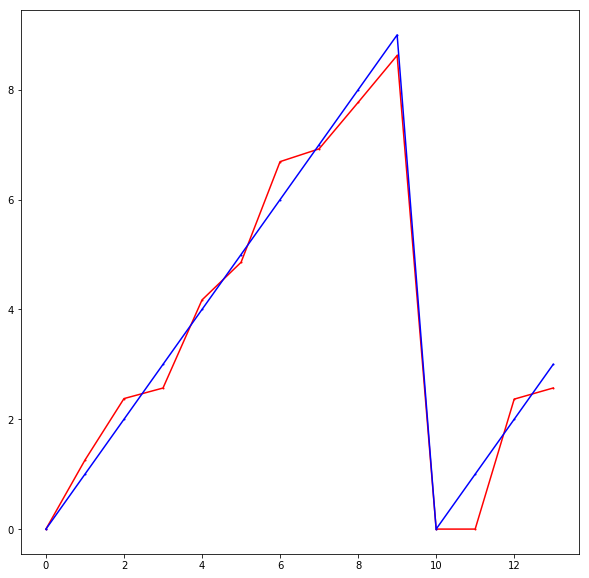

In [256]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(10, 10))
plot=fig.add_subplot(111)
plot.plot(range(len(pred)), pred[:, 0], 'ro-', ms=1)
plot.plot(range(len(pred)), angles[test]%10, 'bo-', ms=1)

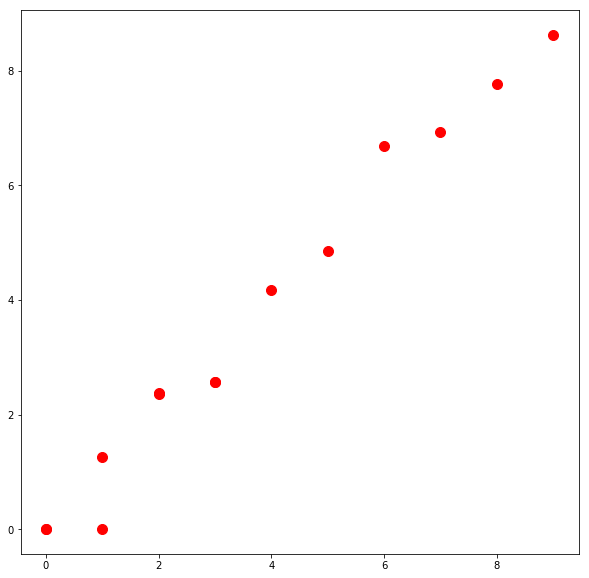

In [258]:
fig=plt.figure(figsize=(10, 10))
plot=fig.add_subplot(111)
plot.plot(angles[test]%10, pred[:, 0], 'ro', ms=10)

In [5]:
import os
os.listdir('C:\\Users\\ЛФКИТ-3\\Documents\\quantTechLab\\data\\auto_rotate')

['img.lnk', 'ints.csv']